# Autoreload and logging config

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment1MicroarrayDataSource').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)
logging.getLogger('download_nextcloud_file').setLevel(logging.DEBUG)

# Download data files

In [2]:
%%time
import os
from epigenetic_clock_assignment import download_file, download_nextcloud_file

data_dir = 'data/assignment1'
meta_filepath = os.path.join(data_dir, 'GSE40279_family.soft-MetaData.csv')
features_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt')
features_gz_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt.gz')

# download meta file if does not exists
download_nextcloud_file(folder_url='https://nc.elte.hu/s/9E36fFCnWML33yN',
                       filename='GSE40279_family.soft-MetaData.csv',
                       out_filepath=meta_filepath,
                       password='GSE40279')

# download features file if does not exists
download_file(url='https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE40279&format=file&file=GSE40279%5Faverage%5Fbeta%2Etxt%2Egz',
              out_filepath=features_filepath,
              intermediate_archive_filepath=features_gz_filepath,
              archive_format='gzip')


DEBUG:download_nextcloud_file:file data/assignment1/GSE40279_family.soft-MetaData.csv already exists; do not download again
DEBUG:download_file:file data/assignment1/GSE40279_average_beta.txt already exists; do not download again


CPU times: user 1.48 s, sys: 4.15 s, total: 5.62 s
Wall time: 1.24 s


# Load data

In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment1MicroarrayDataSource

data_source = Assignment1MicroarrayDataSource(
        meta_filepath=meta_filepath,
        features_filepath=features_filepath
)

X, y = data_source.load()


DEBUG:Assignment1MicroarrayDataSource:load
DEBUG:Assignment1MicroarrayDataSource:joining based on ID
DEBUG:Assignment1MicroarrayDataSource:loaded


CPU times: user 13.1 s, sys: 1.97 s, total: 15.1 s
Wall time: 15.2 s


# Hyperparameter optimization (ElasticNet $\lambda, \alpha$)

In [4]:
%%time
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=2,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test = clock_trainer.train_test_split(X, y, 
                                                                  test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(
    X_train=X_train, 
    y_train=y_train, 
    alpha_count=10 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   20.2s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.1...


STATS      lambda_path  cv_r2_mean_path  cv_r2_std_path      lambda  alpha  \
0   12440.711242         0.204970        0.207524  633.747001    0.0   
1   11335.512743         0.512513        0.057642  633.747001    0.0   
2   10328.497033         0.676166        0.030495  633.747001    0.0   
3    9410.941823         0.679888        0.031493  633.747001    0.0   
4    8574.899689         0.684258        0.031190  633.747001    0.0   
5    7813.129234         0.688742        0.031071  633.747001    0.0   
6    7119.032367         0.692977        0.031645  633.747001    0.0   
7    6486.597153         0.696834        0.032826  633.747001    0.0   
8    5910.345739         0.700202        0.034287  633.747001    0.0   
9    5385.286913         0.703130        0.035751  633.747001    0.0   
10   4906.872866         0.705763        0.037079  633.747001    0.0   
11   4470.959805         0.708232        0.038233  633.747001    0.0   
12   4073.772058         0.710601        0.039229  633.747

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.7s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.2...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0    124.407112         0.002786        0.005399  3.980116    0.1    0.882437   
1    113.355127         0.016720        0.011108  3.980116    0.1    0.882437   
2    103.284970         0.048426        0.021048  3.980116    0.1    0.882437   
3     94.109418         0.098510        0.030009  3.980116    0.1    0.882437   
4     85.748997         0.163459        0.034978  3.980116    0.1    0.882437   
5     78.131292         0.236976        0.036726  3.980116    0.1    0.882437   
6     71.190324         0.313474        0.035204  3.980116    0.1    0.882437   
7     64.865972         0.386229        0.031862  3.980116    0.1    0.882437   
8     59.103457         0.452841        0.027585  3.980116    0.1    0.882437   
9     53.852869         0.512161        0.023127  3.980116    0.1    0.882437   
10    49.068729         0.564277        0.018737  3.980116    0.1    0.882437   
11    44.709598       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.7s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.30000000000000004...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     62.203556         0.007401        0.009987  2.184086    0.2    0.881731   
1     56.677564         0.029699        0.016395  2.184086    0.2    0.881731   
2     51.642485         0.076300        0.027158  2.184086    0.2    0.881731   
3     47.054709         0.137614        0.033422  2.184086    0.2    0.881731   
4     42.874498         0.212587        0.034588  2.184086    0.2    0.881731   
5     39.065646         0.288401        0.032951  2.184086    0.2    0.881731   
6     35.595162         0.361908        0.029973  2.184086    0.2    0.881731   
7     32.432986         0.431051        0.025540  2.184086    0.2    0.881731   
8     29.551729         0.494081        0.021041  2.184086    0.2    0.881731   
9     26.926435         0.549992        0.016602  2.184086    0.2    0.881731   
10    24.534364         0.598327        0.012474  2.184086    0.2    0.881731   
11    22.354799       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   16.0s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.4...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     41.469037         0.011769        0.014344  1.456057    0.3    0.881796   
1     37.785042         0.042148        0.021607  1.456057    0.3    0.881796   
2     34.428323         0.098039        0.029968  1.456057    0.3    0.881796   
3     31.369806         0.165378        0.034628  1.456057    0.3    0.881796   
4     28.582999         0.242335        0.033182  1.456057    0.3    0.881796   
5     26.043764         0.319898        0.030054  1.456057    0.3    0.881796   
6     23.730108         0.391564        0.026089  1.456057    0.3    0.881796   
7     21.621991         0.457062        0.021794  1.456057    0.3    0.881796   
8     19.701152         0.516401        0.017554  1.456057    0.3    0.881796   
9     17.950956         0.569318        0.013326  1.456057    0.3    0.881796   
10    16.356243         0.615511        0.009052  1.456057    0.3    0.881796   
11    14.903199       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.8s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.5...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     31.101778         0.015906        0.018476  1.092043    0.4      0.8814   
1     28.338782         0.054750        0.027381  1.092043    0.4      0.8814   
2     25.821243         0.117186        0.030563  1.092043    0.4      0.8814   
3     23.527355         0.188237        0.034848  1.092043    0.4      0.8814   
4     21.437249         0.265511        0.032523  1.092043    0.4      0.8814   
5     19.532823         0.342128        0.027620  1.092043    0.4      0.8814   
6     17.797581         0.412728        0.023038  1.092043    0.4      0.8814   
7     16.216493         0.476244        0.018337  1.092043    0.4      0.8814   
8     14.775864         0.532921        0.014084  1.092043    0.4      0.8814   
9     13.463217         0.582837        0.010470  1.092043    0.4      0.8814   
10    12.267182         0.626966        0.007095  1.092043    0.4      0.8814   
11    11.177400       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.5s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.6000000000000001...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     24.881422         0.019830        0.022397  0.873634    0.5    0.880966   
1     22.671025         0.066462        0.032640  0.873634    0.5    0.880966   
2     20.656994         0.135384        0.031223  0.873634    0.5    0.880966   
3     18.821884         0.208558        0.033532  0.873634    0.5    0.880966   
4     17.149799         0.285611        0.031721  0.873634    0.5    0.880966   
5     15.626258         0.360648        0.026321  0.873634    0.5    0.880966   
6     14.238065         0.429531        0.020663  0.873634    0.5    0.880966   
7     12.973194         0.490564        0.015698  0.873634    0.5    0.880966   
8     11.820691         0.545202        0.011245  0.873634    0.5    0.880966   
9     10.770574         0.593382        0.007973  0.873634    0.5    0.880966   
10     9.813746         0.635215        0.005562  0.873634    0.5    0.880966   
11     8.941920       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.8s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.7000000000000001...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     20.734519         0.023557        0.026121  0.663353    0.6    0.880537   
1     18.892521         0.077372        0.037444  0.663353    0.6    0.880537   
2     17.214162         0.154233        0.033351  0.663353    0.6    0.880537   
3     15.684903         0.228952        0.032399  0.663353    0.6    0.880537   
4     14.291499         0.304122        0.030106  0.663353    0.6    0.880537   
5     13.021882         0.376868        0.024962  0.663353    0.6    0.880537   
6     11.865054         0.443445        0.019184  0.663353    0.6    0.880537   
7     10.810995         0.502915        0.013767  0.663353    0.6    0.880537   
8      9.850576         0.554987        0.009367  0.663353    0.6    0.880537   
9      8.975478         0.601240        0.006376  0.663353    0.6    0.880537   
10     8.178121         0.641317        0.005465  0.663353    0.6    0.880537   
11     7.451600       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.7s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.8...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     17.772445         0.027100        0.029663  0.624025    0.7    0.879946   
1     16.193590         0.087560        0.041841  0.624025    0.7    0.879946   
2     14.754996         0.172744        0.036308  0.624025    0.7    0.879946   
3     13.444203         0.248625        0.030834  0.624025    0.7    0.879946   
4     12.249857         0.322414        0.028438  0.624025    0.7    0.879946   
5     11.161613         0.393004        0.023373  0.624025    0.7    0.879946   
6     10.170046         0.456954        0.017407  0.624025    0.7    0.879946   
7      9.266567         0.512964        0.011711  0.624025    0.7    0.879946   
8      8.443351         0.562939        0.007421  0.624025    0.7    0.879946   
9      7.693267         0.607210        0.005467  0.624025    0.7    0.879946   
10     7.009818         0.646166        0.006293  0.624025    0.7    0.879946   
11     6.387085       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.7s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.9...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     15.550889         0.030473        0.033035  0.546022    0.8    0.879465   
1     14.169391         0.097092        0.045877  0.546022    0.8    0.879465   
2     12.910621         0.189769        0.038833  0.546022    0.8    0.879465   
3     11.763677         0.269986        0.032052  0.546022    0.8    0.879465   
4     10.718625         0.340696        0.025805  0.546022    0.8    0.879465   
5      9.766412         0.408316        0.021271  0.546022    0.8    0.879465   
6      8.898790         0.470215        0.015364  0.546022    0.8    0.879465   
7      8.108246         0.524328        0.009928  0.546022    0.8    0.879465   
8      7.387932         0.570889        0.005813  0.546022    0.8    0.879465   
9      6.731609         0.612215        0.005231  0.546022    0.8    0.879465   
10     6.133591         0.649668        0.007513  0.546022    0.8    0.879465   
11     5.588700       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   15.3s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 1.0...


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     13.823012         0.033686        0.036247  0.532674    0.9    0.879014   
1     12.595014         0.106028        0.049590  0.532674    0.9    0.879014   
2     11.476108         0.205477        0.040989  0.532674    0.9    0.879014   
3     10.456602         0.289682        0.032965  0.532674    0.9    0.879014   
4      9.527666         0.360907        0.025477  0.532674    0.9    0.879014   
5      8.681255         0.422500        0.018505  0.532674    0.9    0.879014   
6      7.910036         0.481451        0.012841  0.532674    0.9    0.879014   
7      7.207330         0.534312        0.007108  0.532674    0.9    0.879014   
8      6.567051         0.579171        0.003590  0.532674    0.9    0.879014   
9      5.983652         0.617934        0.005425  0.532674    0.9    0.879014   
10     5.452081         0.652436        0.009235  0.532674    0.9    0.879014   
11     4.967733       

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


STATS     lambda_path  cv_r2_mean_path  cv_r2_std_path    lambda  alpha  cv_r2_mean  \
0     12.440711         0.036751        0.039312  0.479406    1.0    0.878818   
1     11.335513         0.114423        0.053012  0.479406    1.0    0.878818   
2     10.328497         0.220011        0.042833  0.479406    1.0    0.878818   
3      9.410942         0.307573        0.033603  0.479406    1.0    0.878818   
4      8.574900         0.380178        0.025231  0.479406    1.0    0.878818   
5      7.813129         0.440696        0.017504  0.479406    1.0    0.878818   
6      7.119032         0.492289        0.009992  0.479406    1.0    0.878818   
7      6.486597         0.541407        0.003760  0.479406    1.0    0.878818   
8      5.910346         0.585652        0.001938  0.479406    1.0    0.878818   
9      5.385287         0.623194        0.006715  0.479406    1.0    0.878818   
10     4.906873         0.655538        0.011149  0.479406    1.0    0.878818   
11     4.470960       

[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   17.6s finished


# Plot hyperparameter optimization result

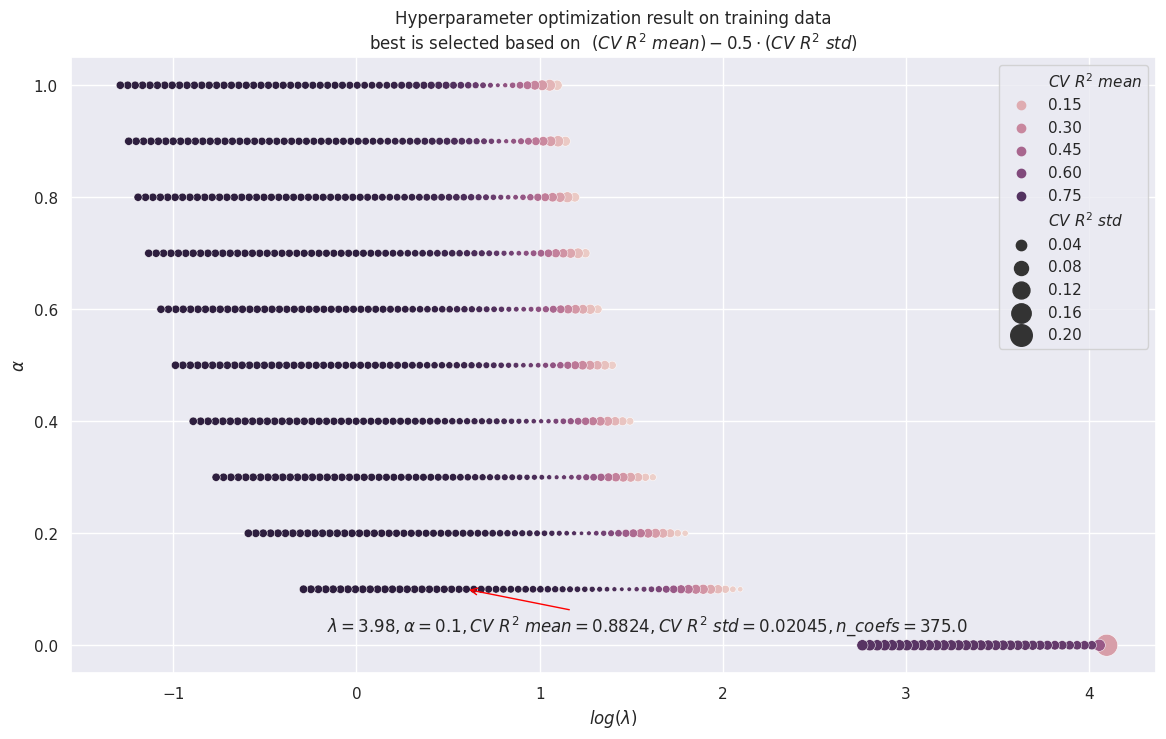

In [5]:
clock_trainer.plot_hyperparameter_optimization_result(hyperparameter_result=hyperparameter_result, hyperparameter_stats=hyperparameter_stats, arrow_xytext_offset=(-100, -30))

# Predict on test data using the best model

In [6]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

# sanity check
assert best_model.alpha == best_alpha
#assert best_model.lambda_best_ == best_lambda

# predict
y_pred = best_model.predict(X = X_test, lamb=best_lambda)

# Plot linear regression result

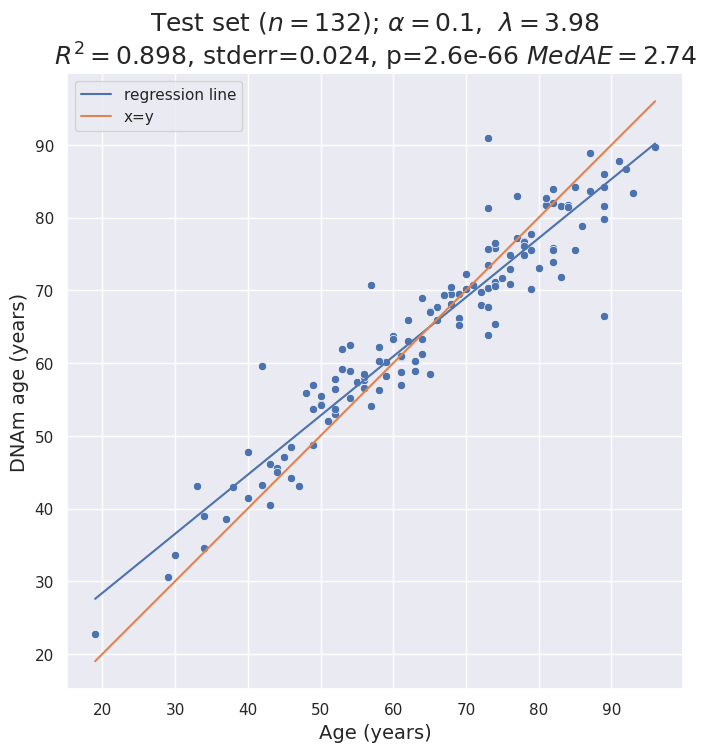

In [7]:
stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(y_true=y_test, y_pred=y_pred, stats=stats, alpha=best_alpha, lamb=best_lambda, title_prefix='Test set')

In [8]:
# TODO: 

# Feature importance based
# Shap Feature Importance
# feature matrix
# glider-nel mint tanitottunk es min teszteltunk
# scatter plot, ahol sok pont van, ott pirosabb (hoterkep)


# delta age  pred - pred age
# delta age az colleral az eletkorral (fiatalokra gyakran lesz pozitiv , oregekre negativ)
# age acc. : prefictalt eletkorbol kivonjuk a regresszios egyenest -> az az erdekes, akik kilognak